In [66]:
import re
import time
import datetime
import csv
import requests
import joblib

# python -m pip install pandas tabulate
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup # для парсера HTML
import openpyxl # для парсера XLSX (Excel)

import pymorphy3 # работа с русским языком, pymorphy3

import texttable as tt

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder # Кодирование категориальных данных

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler # Масштабирование данных

from sklearn.feature_selection import SelectKBest # Выбор признаков с наивысшими оценками
from sklearn.feature_selection import chi2 # Выбор признаков по Хи квадрат

from sklearn.model_selection import train_test_split # Деление выборки на тестовые и тренировочные данные
from sklearn.model_selection import cross_val_score # Оценка качества работы модели

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, mean_absolute_error, classification_report # Критерий качества, точности

from sklearn.neighbors import KNeighborsClassifier # Обучение модели K-ближайших соседей
from sklearn.linear_model import LinearRegression # Линейная регрессия (метод наименьших квадратов)

from sklearn.ensemble import BaggingClassifier # Комплексный метаоценщик
from sklearn.ensemble import RandomForestClassifier # Ансамбли деревьев решений
from sklearn.ensemble import GradientBoostingClassifier # Ансамбли градиентного спуска (повышения градиента)
from sklearn.ensemble import ExtraTreesClassifier # Дополнительные деревья
from sklearn.ensemble import AdaBoostClassifier # Алгоритм усиления ансамбля
from sklearn.ensemble import VotingClassifier # Стэккинг (способ объединения прогнозов)
from sklearn.tree import DecisionTreeClassifier # Деревья решений
from catboost import CatBoostClassifier

# python -m pip install xgboost
from xgboost import XGBClassifier

from sklearn.ensemble import RandomForestRegressor # случайный лес
from sklearn.neighbors import KNeighborsRegressor # метод ближайших соседей
from sklearn.svm import SVR # метод опорных векторов с линейным ядром
from sklearn.linear_model import LogisticRegression # логистическая регрессия

from sklearn.feature_selection import GenericUnivariateSelect, mutual_info_classif # Статистический метод
from sklearn.metrics import r2_score

# python -m pip install mlxtend
from mlxtend.plotting import plot_decision_regions


# Подготавливаю данные о погоде в "село Сембург", близлежайшее поселение к нефтянной скважины №807 (в 24 км). Разрабатываю парсер сайтов о погоде.

In [16]:
# проведу осмотр данных прогноза погоды в с. Самбург на сайте Яндекс.Погода за текущий год (на данный момент это 2023 год)
# lat=66.80035786146756 (Широта)
# lng=78.38975066524623 (Долгота)

month = ['january', 'february', 'march', 'april', 'may', 'june', 'july', 'august', 'september', 'october', 'november', 'december']

morph = pymorphy3.MorphAnalyzer(lang='ru')

data = []
data_i = 0
for j, item in enumerate(month):
  url = 'https://yandex.ru/pogoda/month/{item}?lat={latitude}&lon={lontitude}'
  url = url.format(item=item, latitude=66.80035786146756, lontitude=78.38975066524623)
  print(url)
  page = requests.get(url)
  bs = BeautifulSoup(page.text, 'html.parser')

  # информация о погоде в с. Самбург за каждый месяц
  for i, val in enumerate(bs.find('table', {'class': 'climate-calendar'}).find_all('td', {'class': 'climate-calendar__cell'})):
    temp = []
    if val.find('div', {'class': 'climate-calendar-day_colorless_yes'}):
      continue
    temp.append(int(data_i))
    temp.append(int(val.find('div', {'class': 'climate-calendar-day__detailed-container-center'}).find_next('h6').text.split(',', 1)[0].split(' ', 1)[0]))
    temp.append(str(morph.parse(val.find('div', {'class': 'climate-calendar-day__detailed-container-center'}).find_next('h6').text.split(',', 1)[0].split(' ', 1)[1])[0].normal_form))
    temp.append(2023)
    temp.append(str(val.find('div', {'class': 'climate-calendar-day__detailed-container-center'}).find_next('h6').text.split(',', 1)[1]))
    temp.append(int(val.find('div', {'class': 'temp climate-calendar-day__detailed-basic-temp-day'}).find('span').text.replace('−', '-')))
    temp.append(int(val.find('div', {'class': 'temp climate-calendar-day__detailed-basic-temp-night'}).find('span').text.replace('−', '-')))
    temp.append(int(val.find_all('td', {'class': 'climate-calendar-day__detailed-data-table-cell climate-calendar-day__detailed-data-table-cell_value_yes'})[0].text.split(' ', 1)[0]))
    temp.append(int(val.find_all('td', {'class': 'climate-calendar-day__detailed-data-table-cell climate-calendar-day__detailed-data-table-cell_value_yes'})[1].text.split('%', 1)[0]) / 100)
    temp.append(float(val.find_all('td', {'class': 'climate-calendar-day__detailed-data-table-cell climate-calendar-day__detailed-data-table-cell_value_yes'})[2].find('div').text))
    temp.append(str(val.find_all('td', {'class': 'climate-calendar-day__detailed-data-table-cell climate-calendar-day__detailed-data-table-cell_value_yes'})[2].find('abbr').text))
    print(temp)
    data.append(temp)
    data_i += 1

# Датафрейм из массива
df = pd.DataFrame(data, columns=['id', 'День', 'Месяц', 'Год', 'День недели', 'Температура днем', 'Температура ночью', 'Давление (мм рт. ст.)', 'Влажность (%)', 'Скорость ветра', 'Направление ветра'])
df

https://yandex.ru/pogoda/month/january?lat=66.80035786146756&lon=78.38975066524623
[0, 1, 'январь', 2023, ' вс', -21, -26, 760, 0.76, 5.3, 'ЮВ']
[1, 2, 'январь', 2023, ' пн', -22, -22, 763, 0.79, 5.3, 'З']
[2, 3, 'январь', 2023, ' вт', -21, -22, 764, 0.79, 5.8, 'Ю']
[3, 4, 'январь', 2023, ' ср', -17, -20, 762, 0.81, 6.5, 'Ю']
[4, 5, 'январь', 2023, ' чт', -19, -22, 764, 0.8, 6.0, 'Ю']
[5, 6, 'январь', 2023, ' пт', -20, -22, 766, 0.79, 5.5, 'Ю']
[6, 7, 'январь', 2023, ' сб', -19, -21, 766, 0.76, 4.8, 'Ю']
[7, 8, 'январь', 2023, ' вс', -20, -22, 763, 0.76, 5.3, 'ЮВ']
[8, 9, 'январь', 2023, ' пн', -22, -22, 761, 0.77, 5.5, 'Ю']
[9, 10, 'январь', 2023, ' вт', -21, -24, 760, 0.77, 5.8, 'Ю']
[10, 11, 'январь', 2023, ' ср', -24, -24, 762, 0.76, 5.1, 'Ю']
[11, 12, 'январь', 2023, ' чт', -21, -21, 758, 0.77, 6.5, 'Ю']
[12, 13, 'январь', 2023, ' пт', -19, -22, 756, 0.8, 6.4, 'Ю']
[13, 14, 'январь', 2023, ' сб', -20, -20, 757, 0.79, 5.4, 'ЮВ']
[14, 15, 'январь', 2023, ' вс', -17, -20, 759, 0.8, 4

,id,День,Месяц,Год,День недели,Температура днем,Температура ночью,Давление (мм рт. ст.),Влажность (%),Скорость ветра,Направление ветра
0,0,1,январь,2023,вс,-21,-26,760,0.76,5.3,ЮВ
1,1,2,январь,2023,пн,-22,-22,763,0.79,5.3,З
2,2,3,январь,2023,вт,-21,-22,764,0.79,5.8,Ю
3,3,4,январь,2023,ср,-17,-20,762,0.81,6.5,Ю
4,4,5,январь,2023,чт,-19,-22,764,0.80,6.0,Ю
...,...,...,...,...,...,...,...,...,...,...,...
360,360,27,декабрь,2023,ср,-18,-20,753,0.81,5.5,Ю
361,361,28,декабрь,2023,чт,-18,-20,756,0.81,5.0,Ю
362,362,29,декабрь,2023,пт,-19,-21,759,0.81,5.5,Ю
363,363,30,декабрь,2023,сб,-19,-20,760,0.80,5.8,Ю


In [17]:
# cоздаю объект Texttable
tab = tt.Texttable()

# устанавливаю стили таблицы
tab.set_cols_align(['c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c'])
tab.header(['id', 'День', 'Месяц', 'Год', 'День недели', 'Температура днем', 'Температура ночью', 'Давление (мм рт. ст.)', 'Влажность (%)', 'Скорость ветра', 'Направление ветра'])

# преобразую DataFrame в список списков (двумерный список)
data_list = df.values.tolist()

# добавляю данные в таблицу
for row in data_list:
  tab.add_row(row)

# получаю отформатированную таблицу в виде строки
table_string = tab.draw()

# вывожу таблицу на экран
print(table_string)

+-----+------+-------+------+-------+-------+------+------+------+------+------+
| id  | День | Месяц | Год  | День  | Темпе | Темп | Давл | Влаж | Скор | Напр |
|     |      |       |      | недел | ратур | ерат | ение | ност | ость | авле |
|     |      |       |      |   и   |   а   | ура  | (мм  |  ь   | ветр | ние  |
|     |      |       |      |       | днем  | ночь | рт.  | (%)  |  а   | ветр |
|     |      |       |      |       |       |  ю   | ст.) |      |      |  а   |
+=====+======+=======+======+=======+=======+======+======+======+======+======+
|  0  |  1   | январ | 2023 |   вс  |  -21  | -26  | 760  | 0.76 | 5.30 |  ЮВ  |
|     |      |   ь   |      |       |       |      |      |  0   |  0   |      |
+-----+------+-------+------+-------+-------+------+------+------+------+------+
|  1  |  2   | январ | 2023 |   пн  |  -22  | -22  | 763  | 0.79 | 5.30 |  З   |
|     |      |   ь   |      |       |       |      |      |  0   |  0   |      |
+-----+------+-------+------

# Как видно я получил данные с Яндекс.Погода за 2023 года, мне нужно больше данных. У Яндекс.Погода нет архивных данных, поэтому буду использовать другой сайт с архивными данными.

In [22]:
# рассмотрю данные прогноза погоды в с. Самбург с сайта Погода1 (так как в нем есть архивные данные)
url = 'https://pogoda1.ru/samburg/arkhiv/'
page = requests.get(url)
bs = BeautifulSoup(page.text, 'html.parser')

# Формирую список диапозона даты, где имеются архивные данные
year = bs.find('select', {'class': 'select-archive-year'}).find_all('option')
month = bs.find('select', {'class': 'select-archive-month'}).find_all('option')

# Перевод месяцев с русского на английский язык
def month_translate(month):
  month = month.lower()
  if month == "январь":
    return "january"
  elif month == "февраль":
    return "february"
  elif month == "март":
    return "march"
  elif month == "апрель":
    return "april"
  elif month == "май":
    return "may"
  elif month == "июнь":
    return "june"
  elif month == "июль":
    return "july"
  elif month == "август":
    return "august"
  elif month == "сентябрь":
    return "september"
  elif month == "октябрь":
    return "october"
  elif month == "ноябрь":
    return "november"
  elif month == "декабрь":
    return "december"

base_month = []
for i, val_year in enumerate(year):
  for j, val_month in enumerate(month):
    temp_0 = []
    if j > 0:
      temp_0.append(int(val_year.text))
      temp_0.append(str(month_translate(month = val_month.text)).lower())
      base_month.append(temp_0)

# Формирую список URL адресов с данными
url_parse = 'https://pogoda1.ru/samburg/{month}-{year}/'

for i, val in enumerate(base_month):
  parse = url_parse.format(month=val[1], year=val[0])
  base_month[i].append(parse)

df = pd.DataFrame(base_month, columns=['Год', 'Месяц', 'URL'])
df


,Год,Месяц,URL
0,2017,january,https://pogoda1.ru/samburg/january-2017/
1,2017,february,https://pogoda1.ru/samburg/february-2017/
2,2017,march,https://pogoda1.ru/samburg/march-2017/
3,2017,april,https://pogoda1.ru/samburg/april-2017/
4,2017,may,https://pogoda1.ru/samburg/may-2017/
...,...,...,...
79,2023,august,https://pogoda1.ru/samburg/august-2023/
80,2023,september,https://pogoda1.ru/samburg/september-2023/
81,2023,october,https://pogoda1.ru/samburg/october-2023/
82,2023,november,https://pogoda1.ru/samburg/november-2023/


In [23]:
# Перевод месяцев с текста на цифры
def month_number(month):
  month = month.lower()
  if month == "january":
    return "01"
  elif month == "february":
    return "02"
  elif month == "march":
    return "03"
  elif month == "april":
    return "04"
  elif month == "may":
    return "05"
  elif month == "june":
    return "06"
  elif month == "july":
    return "07"
  elif month == "august":
    return "08"
  elif month == "september":
    return "09"
  elif month == "october":
    return "10"
  elif month == "november":
    return "11"
  elif month == "december":
    return "12"

# Поиск существующих ссылок с данными
base_day = []
for i, val in enumerate(base_month):
  bs = BeautifulSoup(requests.get(val[2]).text, 'html.parser')
  if (bs.find('div', {'class': 'month-calendar calendar'})):
    print(val[2])
    for j, item in enumerate(bs.find_all('a', {'class': 'calendar-item'})):
      temp = []
      if not (item.find('span', {'class': 'no-data'})):
        temp.append(int(val[0]))
        temp.append(int(month_number(val[1])))
        temp.append(int(item.find('span', {'month-calendar-day'}).text))
        temp.append('https://pogoda1.ru' + str(item['href']))
        print(temp)
        base_day.append(temp)

https://pogoda1.ru/samburg/june-2017/
[2017, 6, 7, 'https://pogoda1.ru/samburg/07-06-2017/']
[2017, 6, 8, 'https://pogoda1.ru/samburg/08-06-2017/']
[2017, 6, 9, 'https://pogoda1.ru/samburg/09-06-2017/']
[2017, 6, 10, 'https://pogoda1.ru/samburg/10-06-2017/']
[2017, 6, 11, 'https://pogoda1.ru/samburg/11-06-2017/']
[2017, 6, 12, 'https://pogoda1.ru/samburg/12-06-2017/']
[2017, 6, 13, 'https://pogoda1.ru/samburg/13-06-2017/']
[2017, 6, 14, 'https://pogoda1.ru/samburg/14-06-2017/']
[2017, 6, 15, 'https://pogoda1.ru/samburg/15-06-2017/']
[2017, 6, 16, 'https://pogoda1.ru/samburg/16-06-2017/']
[2017, 6, 17, 'https://pogoda1.ru/samburg/17-06-2017/']
[2017, 6, 18, 'https://pogoda1.ru/samburg/18-06-2017/']
[2017, 6, 19, 'https://pogoda1.ru/samburg/19-06-2017/']
[2017, 6, 20, 'https://pogoda1.ru/samburg/20-06-2017/']
[2017, 6, 21, 'https://pogoda1.ru/samburg/21-06-2017/']
[2017, 6, 22, 'https://pogoda1.ru/samburg/22-06-2017/']
[2017, 6, 23, 'https://pogoda1.ru/samburg/23-06-2017/']
[2017, 6, 24,

In [104]:
# Парсер погоды
data = []
for i, val in enumerate(base_day):
  # if i < 1593:
  #   continue
  temp = []
  bs = BeautifulSoup(requests.get(val[3]).text, 'html.parser')
  if not (bs.find('div', {'class': 'panel-heading'}).text == '404 Страница не найдена'):
    # print(val[3])
    temp.append(i)
    temp.append(val[0])
    temp.append(val[1])
    temp.append(val[2])
    temp.append(str(bs.find('img', {'class': 'weather-now-icon-img'})['title']).lower())
    if (bs.find('div', {'class': 'weather-now-col weather-now-col-main'}).find('span', {'class': 'wind-amount'})):
      temp.append(str(bs.find_all('span', {'class': 'wind-amount'})[0].text.split(',', 1)[0]).lower())
      temp.append(int(bs.find_all('span', {'class': 'wind-amount'})[0].text.split(',', 1)[1].split(' ', 2)[1]))
    else:
      for j, item in enumerate(bs.find_all('div', {'row-forecast-time-of-day'})):
        if not (str(item.find('div', {'class': 'cell-forecast-wind'}).find('span', {'class': 'wind'}).text) == 'нет'):
          temp.append(str(item.find('div', {'class': 'cell-forecast-wind'}).find('img', {'class': 'icon-wind'})['title'].split(' ', 1)[0]).lower())
          temp.append(int(item.find('div', {'class': 'cell-forecast-wind'}).find('span', {'class': 'wind-amount'}).text.split(' ', 1)[0]))
        else:
          temp.append('')
          temp.append('')
        break
    temp.append(int(bs.find_all('div', {'class': 'weather-now-info'})[0].find('span', {'class': 'value'}).text.split(' ', 1)[0]))
    temp.append(int(bs.find_all('div', {'class': 'weather-now-info'})[1].find('span', {'class': 'value'}).text.split('%', 1)[0]))
    temp.append(float(bs.find_all('div', {'class': 'weather-now-info'})[2].find('span', {'class': 'value'}).text.split(' ', 1)[0]))
    temp.append(str(bs.find_all('div', {'class': 'weather-now-info'})[6].find('span', {'class': 'value'}).text.split(' ', 1)[0]).lower())
    # temp.append(int(bs.find_all('div', {'class': 'weather-now-info'})[6].find('span', {'class': 'value'}).text.split(' ', 1)[1].split('%', 1)[0]))
    if not (str(bs.find_all('div', {'row-forecast-time-of-day'})[2].find('div', {'class': 'cell-forecast-prec opened'}))):
      if (str(bs.find_all('div', {'row-forecast-time-of-day'})[2].find('div', {'class': 'cell-forecast-prec'}).text) == 'без осадков'):
        temp.append(0)
      else:
        temp.append(float(bs.find_all('div', {'row-forecast-time-of-day'})[2].find('div', {'class': 'cell-forecast-prec'}).text.split(' ', 1)[0]))
    else:
      if (str(bs.find_all('div', {'row-forecast-time-of-day'})[1].find('div', {'class': 'cell-forecast-prec'}).text) == 'без осадков'):
        temp.append(0)
      else:
        temp.append(float(bs.find_all('div', {'row-forecast-time-of-day'})[1].find('div', {'class': 'cell-forecast-prec'}).text.split(' ', 1)[0]))
    temp.append(int(bs.find_all('div', {'row-forecast-time-of-day'})[0].find('div', {'class': 'cell-forecast-temp'}).text.split('°', 1)[0]))
    if not (str(bs.find_all('div', {'row-forecast-time-of-day'})[2].find('div', {'class': 'cell-forecast-prec opened'}))):
      temp.append(int(bs.find_all('div', {'row-forecast-time-of-day'})[2].find('div', {'class': 'cell-forecast-temp'}).text.split('°', 1)[0]))
    else:
      temp.append(int(bs.find_all('div', {'row-forecast-time-of-day'})[1].find('div', {'class': 'cell-forecast-temp'}).text.split('°', 1)[0]))
    temp.append(val[3])
    print(temp)
    data.append(temp)

[0, 2017, 6, 7, 'пасмурно', 'северо-западный', 4, 764, 56, 10.0, 'растущая', 0, 9, 13, 'https://pogoda1.ru/samburg/07-06-2017/']
[1, 2017, 6, 8, 'ясно', 'северо-западный', 3, 762, 63, 10.0, 'растущая', 0, 9, 13, 'https://pogoda1.ru/samburg/08-06-2017/']
[2, 2017, 6, 9, 'малооблачно', 'северный', 3, 756, 51, 10.0, 'полнолуние', 0, 12, 15, 'https://pogoda1.ru/samburg/09-06-2017/']
[3, 2017, 6, 10, 'пасмурно', 'северо-западный', 8, 752, 60, 10.0, 'убывающая', 0, 10, 10, 'https://pogoda1.ru/samburg/10-06-2017/']
[4, 2017, 6, 11, 'пасмурно', 'западный', 6, 756, 50, 10.0, 'убывающая', 0, 4, 2, 'https://pogoda1.ru/samburg/11-06-2017/']
[5, 2017, 6, 12, 'пасмурно', 'южный', 6, 758, 70, 10.0, 'убывающая', 0, 5, 12, 'https://pogoda1.ru/samburg/12-06-2017/']
[6, 2017, 6, 13, 'пасмурно', 'юго-восточный', 2, 758, 100, 10.0, 'убывающая', 1.1, 5, 9, 'https://pogoda1.ru/samburg/13-06-2017/']
[7, 2017, 6, 14, 'пасмурно', 'южный', 9, 759, 65, 10.0, 'убывающая', 0, 6, 15, 'https://pogoda1.ru/samburg/14-0

In [188]:
# Оформляю в DataFrame
df = pd.DataFrame(data, columns=[
  'id',
  'год',
  'месяц',
  'день',
  'погодное условие',
  'направление ветра',
  'скорость ветра (м/с)',
  'давление (мм рт. ст.)',
  'влажность (%)',
  'видимость (мм)',
  'луна',
  'осадки (мм)',
  'температура днем',
  'температура ночью',
  'url'
])
# df.drop(columns=["id"], inplace=True)

# Сохранение данных в csv
df.to_csv('data_samburg_weather.csv', sep=',', encoding='utf-8', index=False)
df

,год,месяц,день,погодное условие,направление ветра,скорость ветра (м/с),давление (мм рт. ст.),влажность (%),видимость (мм),луна,осадки (мм),температура днем,температура ночью,url
0,2017,6,7,пасмурно,северо-западный,4,764,56,10.0,растущая,0.0,9,13,https://pogoda1.ru/samburg/07-06-2017/
1,2017,6,8,ясно,северо-западный,3,762,63,10.0,растущая,0.0,9,13,https://pogoda1.ru/samburg/08-06-2017/
2,2017,6,9,малооблачно,северный,3,756,51,10.0,полнолуние,0.0,12,15,https://pogoda1.ru/samburg/09-06-2017/
3,2017,6,10,пасмурно,северо-западный,8,752,60,10.0,убывающая,0.0,10,10,https://pogoda1.ru/samburg/10-06-2017/
4,2017,6,11,пасмурно,западный,6,756,50,10.0,убывающая,0.0,4,2,https://pogoda1.ru/samburg/11-06-2017/
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2345,2023,11,15,снег,юго-западный,10,763,92,10.0,растущая,0.9,-4,-8,https://pogoda1.ru/samburg/15-11-2023/
2346,2023,11,16,снег,юго-западный,5,762,96,10.0,растущая,1.0,-3,-4,https://pogoda1.ru/samburg/16-11-2023/
2347,2023,11,17,снег,северный,8,759,93,10.0,растущая,1.5,-19,-4,https://pogoda1.ru/samburg/17-11-2023/
2348,2023,11,18,пасмурно,северный,7,765,89,10.0,растущая,0.0,-19,-21,https://pogoda1.ru/samburg/18-11-2023/


# Необходимые данные получил в размере 2350 строк. Сохранил данные в файл и загрузил к себе в Git репозиторий. Дальше идет подготовка данных, а именно просмотр пустот и заполнения средними или наиболее встречающимися значениями, просмотр типов данных.

In [2]:
# Загрузка файла из Git моего репозитория в Pandas
# data_samburg_weather = pd.read_csv('https://raw.githubusercontent.com/SotGE/innopolis2023/main/exam/data_samburg_weather.csv', sep=',', index_col=False, quoting=csv.QUOTE_MINIMAL)
data_samburg_weather = pd.read_csv('https://raw.githubusercontent.com/SotGE/innopolis2023/main/exam/data_samburg_weather.csv', sep=',', index_col=False)
data_samburg_weather

,id,год,месяц,день,погодное условие,направление ветра,скорость ветра (м/с),давление (мм рт. ст.),влажность (%),видимость (мм),луна,осадки (мм),температура днем,температура ночью,url
0,0,2017,6,7,пасмурно,северо-западный,4.0,764,56,10.0,растущая,0.0,9,13,https://pogoda1.ru/samburg/07-06-2017/
1,1,2017,6,8,ясно,северо-западный,3.0,762,63,10.0,растущая,0.0,9,13,https://pogoda1.ru/samburg/08-06-2017/
2,2,2017,6,9,малооблачно,северный,3.0,756,51,10.0,полнолуние,0.0,12,15,https://pogoda1.ru/samburg/09-06-2017/
3,3,2017,6,10,пасмурно,северо-западный,8.0,752,60,10.0,убывающая,0.0,10,10,https://pogoda1.ru/samburg/10-06-2017/
4,4,2017,6,11,пасмурно,западный,6.0,756,50,10.0,убывающая,0.0,4,2,https://pogoda1.ru/samburg/11-06-2017/
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2345,2345,2023,11,15,снег,юго-западный,10.0,763,92,10.0,растущая,0.9,-4,-8,https://pogoda1.ru/samburg/15-11-2023/
2346,2346,2023,11,16,снег,юго-западный,5.0,762,96,10.0,растущая,1.0,-3,-4,https://pogoda1.ru/samburg/16-11-2023/
2347,2347,2023,11,17,снег,северный,8.0,759,93,10.0,растущая,1.5,-19,-4,https://pogoda1.ru/samburg/17-11-2023/
2348,2348,2023,11,18,пасмурно,северный,7.0,765,89,10.0,растущая,0.0,-19,-21,https://pogoda1.ru/samburg/18-11-2023/


In [68]:
# Размер данных (количество строк, колонок)
data_samburg_weather.shape

(2350, 15)

In [136]:
# Просмотр типов данных в датасете
print(data_samburg_weather.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2350 entries, 0 to 2349
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             2350 non-null   int64  
 1   год                    2350 non-null   int64  
 2   месяц                  2350 non-null   int64  
 3   день                   2350 non-null   int64  
 4   погодное условие       2350 non-null   object 
 5   направление ветра      2348 non-null   object 
 6   скорость ветра (м/с)   2348 non-null   float64
 7   давление (мм рт. ст.)  2350 non-null   int64  
 8   влажность (%)          2350 non-null   int64  
 9   видимость (мм)         2350 non-null   float64
 10  луна                   2350 non-null   object 
 11  осадки (мм)            2350 non-null   float64
 12  температура днем       2350 non-null   int64  
 13  температура ночью      2350 non-null   int64  
 14  url                    2350 non-null   object 
dtypes: f

In [137]:
# Проверка данных

# Количество пустых ячеек
data_samburg_weather.isnull().sum()

Unnamed: 0               0
год                      0
месяц                    0
день                     0
погодное условие         0
направление ветра        2
скорость ветра (м/с)     2
давление (мм рт. ст.)    0
влажность (%)            0
видимость (мм)           0
луна                     0
осадки (мм)              0
температура днем         0
температура ночью        0
url                      0
dtype: int64

In [131]:
# Количество неопределенные значений (неправильно считанные)
data_samburg_weather.isna().sum()

Unnamed: 0               0
год                      0
месяц                    0
день                     0
погодное условие         0
направление ветра        2
скорость ветра (м/с)     2
давление (мм рт. ст.)    0
влажность (%)            0
видимость (мм)           0
луна                     0
осадки (мм)              0
температура днем         0
температура ночью        0
url                      0
dtype: int64

In [107]:
# Колличество пустых строк
(data_samburg_weather == "").sum()

Unnamed: 0               0
год                      0
месяц                    0
день                     0
погодное условие         0
направление ветра        0
скорость ветра (м/с)     0
давление (мм рт. ст.)    0
влажность (%)            0
видимость (мм)           0
луна                     0
осадки (мм)              0
температура днем         0
температура ночью        0
url                      0
dtype: int64

In [3]:
# Заполнение данных

# Заполнение пустых значений - наиболее встречающимся классом
# df['направление ветра'] = df['направление ветра'].replace('', str(df['направление ветра'].value_counts().index[0]))
data_samburg_weather['направление ветра'].fillna(str(data_samburg_weather['направление ветра'].value_counts().index[0]), inplace = True)

# Заполнение пустых значений - наиболее распространенного значения
# data_samburg_weather['скорость ветра (м/с)'] = data_samburg_weather['скорость ветра (м/с)'].replace('', float(data_samburg_weather['скорость ветра (м/с)'].value_counts().idxmax()))
data_samburg_weather['скорость ветра (м/с)'].fillna(float(data_samburg_weather['скорость ветра (м/с)'].value_counts().idxmax()), inplace = True)

data_samburg_weather = data_samburg_weather.astype({'скорость ветра (м/с)': 'float64'})

In [12]:
# Просмотр типов данных в датасете
print(data_samburg_weather.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2350 entries, 0 to 2349
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2350 non-null   int64  
 1   год                    2350 non-null   int64  
 2   месяц                  2350 non-null   int64  
 3   день                   2350 non-null   int64  
 4   погодное условие       2350 non-null   object 
 5   направление ветра      2350 non-null   object 
 6   скорость ветра (м/с)   2350 non-null   float64
 7   давление (мм рт. ст.)  2350 non-null   int64  
 8   влажность (%)          2350 non-null   int64  
 9   видимость (мм)         2350 non-null   float64
 10  луна                   2350 non-null   object 
 11  осадки (мм)            2350 non-null   float64
 12  температура днем       2350 non-null   int64  
 13  температура ночью      2350 non-null   int64  
 14  url                    2350 non-null   object 
dtypes: f

In [13]:
# Повторная проверка данных

# Количество пустых ячеек
data_samburg_weather.isnull().sum()

id                       0
год                      0
месяц                    0
день                     0
погодное условие         0
направление ветра        0
скорость ветра (м/с)     0
давление (мм рт. ст.)    0
влажность (%)            0
видимость (мм)           0
луна                     0
осадки (мм)              0
температура днем         0
температура ночью        0
url                      0
dtype: int64

In [14]:
# Количество неопределенные значений (неправильно считанные)
data_samburg_weather.isna().sum()

id                       0
год                      0
месяц                    0
день                     0
погодное условие         0
направление ветра        0
скорость ветра (м/с)     0
давление (мм рт. ст.)    0
влажность (%)            0
видимость (мм)           0
луна                     0
осадки (мм)              0
температура днем         0
температура ночью        0
url                      0
dtype: int64

In [143]:
# Колличество пустых строк
(data_samburg_weather == '').sum()

Unnamed: 0               0
год                      0
месяц                    0
день                     0
погодное условие         0
направление ветра        0
скорость ветра (м/с)     0
давление (мм рт. ст.)    0
влажность (%)            0
видимость (мм)           0
луна                     0
осадки (мм)              0
температура днем         0
температура ночью        0
url                      0
dtype: int64

In [15]:
# Описательная статистика
data_samburg_weather.describe(include='all', percentiles=[0.1, 0.25,0.5, 0.75, 0.9]).T

,count,unique,top,freq,mean,std,min,10%,25%,50%,75%,90%,max
id,2350.0,NaN,NaN,NaN,1174.5,678.530889,0.0,234.9,587.25,1174.5,1761.75,2114.1,2349.0
год,2350.0,NaN,NaN,NaN,2020.155319,1.881358,2017.0,2018.0,2019.0,2020.0,2022.0,2023.0,2023.0
месяц,2350.0,NaN,NaN,NaN,6.659149,3.390316,1.0,2.0,4.0,7.0,10.0,11.0,12.0
день,2350.0,NaN,NaN,NaN,15.701702,8.793305,1.0,4.0,8.0,16.0,23.0,28.0,31.0
погодное условие,2350,6,пасмурно,1549,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
направление ветра,2350,8,южный,445,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
скорость ветра (м/с),2350.0,NaN,NaN,NaN,5.511489,2.76689,1.0,2.0,4.0,5.0,7.0,9.0,44.0
давление (мм рт. ст.),2350.0,NaN,NaN,NaN,759.973617,9.550216,729.0,748.0,754.0,759.0,765.0,772.0,806.0
влажность (%),2350.0,NaN,NaN,NaN,79.794468,17.196529,0.0,52.0,70.0,85.0,93.0,97.0,100.0
видимость (мм),2350.0,NaN,NaN,NaN,23.398,86.264654,1.0,10.0,10.0,10.0,10.0,10.0,992.0


# На этом парсер погоды закончен, перехожу к подготовке датасета о нефтянной скважины №807 (данные хранятся в формате xlsx, их переведу в формат csv).

In [175]:
# загружаю xlsx документ и выполняю парсер
wookbook = openpyxl.load_workbook('Oil well.xlsx')
worksheet = wookbook["Oil Well"]
data_xlsx = []
data_i = 0
for row in worksheet.iter_rows(min_row=4, min_col=1, max_col=9):
  temp = []
  temp.append(data_i)
  for j, cell in enumerate(row):
    if j == 0:
      temp.append(cell.value.year)
      temp.append(cell.value.month)
      temp.append(cell.value.day)
    else:
      temp.append(cell.value)
  data_xlsx.append(temp)
  data_i += 1

df = pd.DataFrame(data_xlsx, columns=[
  'id',
  'год',
  'месяц',
  'день',
  'объем нефти (м3/сутки)',
  'объем жидкости (м3/сутки)',
  'объем газа (м3/сутки)',
  'объем воды (м3/сутки)',
  'обводненность (%)',
  'рабочее время',
  'динамический уровень (м)',
  'пластовое давление (атм)'
])
# df.drop(columns=["id"], inplace=True)

# Сохранение данных в csv
df.to_csv('data_oil_well_807.csv', sep=',', encoding='utf-8', index=False)
df

,id,год,месяц,день,объем нефти (м3/сутки),объем жидкости (м3/сутки),объем газа (м3/сутки),объем воды (м3/сутки),обводненность (%),рабочее время,динамический уровень (м),пластовое давление (атм)
0,0,2013,1,1,49,70,13055,21,29,24,1819,214
1,1,2013,1,2,49,70,13055,21,29,24,1836,214
2,2,2013,1,3,49,70,13055,21,29,24,1788,214
3,3,2013,1,4,49,70,13055,21,29,24,1789,214
4,4,2013,1,5,44,70,11768,26,36,24,1825,214
...,...,...,...,...,...,...,...,...,...,...,...,...
2934,2934,2021,1,14,6,20,1593,15,70,16,2101,100
2935,2935,2021,1,15,6,20,1593,15,70,16,2113,100
2936,2936,2021,1,16,6,20,1583,14,70,16,2125,100
2937,2937,2021,1,17,6,20,1573,14,70,16,2125,100


# Необходимые данные получил в размере 2939 строк. Сохранил данные в файл и загрузил к себе в Git репозиторий. Дальше идет подготовка данных, а именно просмотр пустот и заполнения средними или наиболее встречающимися значениями, просмотр типов данных.

In [4]:
# Загрузка файла из Git моего репозитория в Pandas
# data_oil_well_807 = pWd.read_csv('https://raw.githubusercontent.com/SotGE/innopolis2023/main/exam/data_oil_well_807.csv', sep=',', index_col=False, quoting=csv.QUOTE_MINIMAL)
data_oil_well_807 = pd.read_csv('https://raw.githubusercontent.com/SotGE/innopolis2023/main/exam/data_oil_well_807.csv', sep=',', index_col=False)
data_oil_well_807

,id,год,месяц,день,объем нефти (м3/сутки),объем жидкости (м3/сутки),объем газа (м3/сутки),объем воды (м3/сутки),обводненность (%),рабочее время,динамический уровень (м),пластовое давление (атм)
0,0,2013,1,1,49,70,13055,21,29,24,1819,214
1,1,2013,1,2,49,70,13055,21,29,24,1836,214
2,2,2013,1,3,49,70,13055,21,29,24,1788,214
3,3,2013,1,4,49,70,13055,21,29,24,1789,214
4,4,2013,1,5,44,70,11768,26,36,24,1825,214
...,...,...,...,...,...,...,...,...,...,...,...,...
2934,2934,2021,1,14,6,20,1593,15,70,16,2101,100
2935,2935,2021,1,15,6,20,1593,15,70,16,2113,100
2936,2936,2021,1,16,6,20,1583,14,70,16,2125,100
2937,2937,2021,1,17,6,20,1573,14,70,16,2125,100


In [4]:
# Размер данных (количество строк, колонок)
data_oil_well_807.shape

(2939, 12)

In [5]:
# Просмотр типов данных в датасете
print(data_oil_well_807.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2939 entries, 0 to 2938
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   id                         2939 non-null   int64
 1   год                        2939 non-null   int64
 2   месяц                      2939 non-null   int64
 3   день                       2939 non-null   int64
 4   объем нефти (м3/сутки)     2939 non-null   int64
 5   объем жидкости (м3/сутки)  2939 non-null   int64
 6   объем газа (м3/сутки)      2939 non-null   int64
 7   объем воды (м3/сутки)      2939 non-null   int64
 8   обводненность (%)          2939 non-null   int64
 9   рабочее время              2939 non-null   int64
 10  динамический уровень (м)   2939 non-null   int64
 11  пластовое давление (атм)   2939 non-null   int64
dtypes: int64(12)
memory usage: 275.7 KB
None


In [6]:
# Проверка данных

# Количество пустых ячеек
data_oil_well_807.isnull().sum()

id                           0
год                          0
месяц                        0
день                         0
объем нефти (м3/сутки)       0
объем жидкости (м3/сутки)    0
объем газа (м3/сутки)        0
объем воды (м3/сутки)        0
обводненность (%)            0
рабочее время                0
динамический уровень (м)     0
пластовое давление (атм)     0
dtype: int64

In [7]:
# Количество неопределенные значений (неправильно считанные)
data_oil_well_807.isna().sum()

id                           0
год                          0
месяц                        0
день                         0
объем нефти (м3/сутки)       0
объем жидкости (м3/сутки)    0
объем газа (м3/сутки)        0
объем воды (м3/сутки)        0
обводненность (%)            0
рабочее время                0
динамический уровень (м)     0
пластовое давление (атм)     0
dtype: int64

In [8]:
# Колличество пустых строк
(data_oil_well_807 == '').sum()

id                           0
год                          0
месяц                        0
день                         0
объем нефти (м3/сутки)       0
объем жидкости (м3/сутки)    0
объем газа (м3/сутки)        0
объем воды (м3/сутки)        0
обводненность (%)            0
рабочее время                0
динамический уровень (м)     0
пластовое давление (атм)     0
dtype: int64

In [9]:
# Описательная статистика
data_oil_well_807.describe(include='all', percentiles=[0.1, 0.25,0.5, 0.75, 0.9]).T

,count,mean,std,min,10%,25%,50%,75%,90%,max
id,2939.0,1469.000000,848.560546,0.0,293.8,734.5,1469.0,2203.5,2644.2,2938.0
год,2939.0,2016.529092,2.311826,2013.0,2013.0,2015.0,2017.0,2019.0,2020.0,2021.0
месяц,2939.0,6.489622,3.466087,1.0,2.0,3.0,7.0,10.0,11.0,12.0
день,2939.0,15.686288,8.794391,1.0,4.0,8.0,16.0,23.0,28.0,31.0
объем нефти (м3/сутки),2939.0,17.624362,9.689026,0.0,8.0,11.0,15.0,22.0,32.0,49.0
объем жидкости (м3/сутки),2939.0,59.464103,18.634101,12.0,32.0,50.0,58.0,74.0,83.0,113.0
объем газа (м3/сутки),2939.0,4730.146308,2598.888524,4.0,2134.8,3041.5,3909.0,5843.5,8511.0,13113.0
объем воды (м3/сутки),2939.0,41.828853,13.056625,9.0,23.0,33.0,43.0,50.0,58.0,99.0
обводненность (%),2939.0,70.694794,9.534203,29.0,59.0,69.0,73.0,76.0,78.0,100.0
рабочее время,2939.0,22.344675,3.039553,7.0,17.0,22.0,24.0,24.0,24.0,24.0


# На этом парсер нефтянной скважины №807 закончен. Теперь есть 2 датасета: data_samburg_weather.csv и data_oil_well_807.csv

In [5]:
# найду общие даты между ними и обрежу датасеты (объеденение 2х датасетов в один)
# data_samburg_weather
# data_oil_well_807

data = data_samburg_weather.merge(data_oil_well_807, how='inner', on=['год', 'месяц', 'день'])
data


,id_x,год,месяц,день,погодное условие,направление ветра,скорость ветра (м/с),давление (мм рт. ст.),влажность (%),видимость (мм),...,url,id_y,объем нефти (м3/сутки),объем жидкости (м3/сутки),объем газа (м3/сутки),объем воды (м3/сутки),обводненность (%),рабочее время,динамический уровень (м),пластовое давление (атм)
0,0,2017,6,7,пасмурно,северо-западный,4.0,764,56,10.0,...,https://pogoda1.ru/samburg/07-06-2017/,1617,16,52,4210,36,69,24,1841,151
1,1,2017,6,8,ясно,северо-западный,3.0,762,63,10.0,...,https://pogoda1.ru/samburg/08-06-2017/,1618,16,52,4210,36,69,24,1851,151
2,2,2017,6,9,малооблачно,северный,3.0,756,51,10.0,...,https://pogoda1.ru/samburg/09-06-2017/,1619,16,52,4210,36,69,24,1851,151
3,3,2017,6,10,пасмурно,северо-западный,8.0,752,60,10.0,...,https://pogoda1.ru/samburg/10-06-2017/,1620,16,52,4210,36,69,24,1851,151
4,4,2017,6,11,пасмурно,западный,6.0,756,50,10.0,...,https://pogoda1.ru/samburg/11-06-2017/,1621,16,52,4210,36,69,24,1860,151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1310,1310,2021,1,14,снег,западный,8.0,763,95,380.0,...,https://pogoda1.ru/samburg/14-01-2021/,2934,6,20,1593,15,70,16,2101,100
1311,1311,2021,1,15,пасмурно,юго-западный,3.0,770,87,10.0,...,https://pogoda1.ru/samburg/15-01-2021/,2935,6,20,1593,15,70,16,2113,100
1312,1312,2021,1,16,пасмурно,юго-восточный,5.0,759,93,7.4,...,https://pogoda1.ru/samburg/16-01-2021/,2936,6,20,1583,14,70,16,2125,100
1313,1313,2021,1,17,снег,восточный,8.0,747,93,132.0,...,https://pogoda1.ru/samburg/17-01-2021/,2937,6,20,1573,14,70,16,2125,100


In [6]:
# удалю ненужные столбцы
data.drop(columns=[
  'id_x',
  'url',
  'id_y'
], inplace=True)
data

,год,месяц,день,погодное условие,направление ветра,скорость ветра (м/с),давление (мм рт. ст.),влажность (%),видимость (мм),луна,...,температура днем,температура ночью,объем нефти (м3/сутки),объем жидкости (м3/сутки),объем газа (м3/сутки),объем воды (м3/сутки),обводненность (%),рабочее время,динамический уровень (м),пластовое давление (атм)
0,2017,6,7,пасмурно,северо-западный,4.0,764,56,10.0,растущая,...,9,13,16,52,4210,36,69,24,1841,151
1,2017,6,8,ясно,северо-западный,3.0,762,63,10.0,растущая,...,9,13,16,52,4210,36,69,24,1851,151
2,2017,6,9,малооблачно,северный,3.0,756,51,10.0,полнолуние,...,12,15,16,52,4210,36,69,24,1851,151
3,2017,6,10,пасмурно,северо-западный,8.0,752,60,10.0,убывающая,...,10,10,16,52,4210,36,69,24,1851,151
4,2017,6,11,пасмурно,западный,6.0,756,50,10.0,убывающая,...,4,2,16,52,4210,36,69,24,1860,151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1310,2021,1,14,снег,западный,8.0,763,95,380.0,растущая,...,-13,-13,6,20,1593,15,70,16,2101,100
1311,2021,1,15,пасмурно,юго-западный,3.0,770,87,10.0,растущая,...,-20,-21,6,20,1593,15,70,16,2113,100
1312,2021,1,16,пасмурно,юго-восточный,5.0,759,93,7.4,растущая,...,-17,-16,6,20,1583,14,70,16,2125,100
1313,2021,1,17,снег,восточный,8.0,747,93,132.0,растущая,...,-19,-19,6,20,1573,14,70,16,2125,100


# Данные для исседования подготовил.

In [63]:
# Проверка значений на 0
(data == 0).sum()

# Как видно, представленные параметры могут находится в значении 0

# Заполнение нулевых значений - медианой не требуется
# data = data.replace(0, data.median())

год                             0
месяц                           0
день                            0
погодное условие                0
направление ветра               0
скорость ветра (м/с)            0
давление (мм рт. ст.)           0
влажность (%)                   5
видимость (мм)                  0
луна                            0
осадки (мм)                  1033
температура днем               83
температура ночью              77
объем нефти (м3/сутки)          1
объем жидкости (м3/сутки)       0
объем газа (м3/сутки)           0
объем воды (м3/сутки)           0
обводненность (%)               0
рабочее время                   0
динамический уровень (м)        0
пластовое давление (атм)        0
dtype: int64

In [12]:
# Просмотр типов данных в датасете
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1315 entries, 0 to 1314
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   год                        1315 non-null   int64  
 1   месяц                      1315 non-null   int64  
 2   день                       1315 non-null   int64  
 3   погодное условие           1315 non-null   object 
 4   направление ветра          1315 non-null   object 
 5   скорость ветра (м/с)       1315 non-null   float64
 6   давление (мм рт. ст.)      1315 non-null   int64  
 7   влажность (%)              1315 non-null   int64  
 8   видимость (мм)             1315 non-null   float64
 9   луна                       1315 non-null   object 
 10  осадки (мм)                1315 non-null   float64
 11  температура днем           1315 non-null   int64  
 12  температура ночью          1315 non-null   int64  
 13  объем нефти (м3/сутки)     1315 non-null   int64

In [7]:
# Перевел категориальные данные - строковые в числовые с сортировкой по алфавиту
data['погодное условие'] = pd.factorize(data['погодное условие'].astype("category"), sort=True)[0]+1
data['направление ветра'] = pd.factorize(data['направление ветра'].astype("category"), sort=True)[0]+1
data['луна'] = pd.factorize(data['луна'].astype("category"), sort=True)[0]+1
data

,год,месяц,день,погодное условие,направление ветра,скорость ветра (м/с),давление (мм рт. ст.),влажность (%),видимость (мм),луна,...,температура днем,температура ночью,объем нефти (м3/сутки),объем жидкости (м3/сутки),объем газа (м3/сутки),объем воды (м3/сутки),обводненность (%),рабочее время,динамический уровень (м),пластовое давление (атм)
0,2017,6,7,4,5,4.0,764,56,10.0,3,...,9,13,16,52,4210,36,69,24,1841,151
1,2017,6,8,6,5,3.0,762,63,10.0,3,...,9,13,16,52,4210,36,69,24,1851,151
2,2017,6,9,2,3,3.0,756,51,10.0,2,...,12,15,16,52,4210,36,69,24,1851,151
3,2017,6,10,4,5,8.0,752,60,10.0,4,...,10,10,16,52,4210,36,69,24,1851,151
4,2017,6,11,4,2,6.0,756,50,10.0,4,...,4,2,16,52,4210,36,69,24,1860,151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1310,2021,1,14,5,2,8.0,763,95,380.0,3,...,-13,-13,6,20,1593,15,70,16,2101,100
1311,2021,1,15,4,7,3.0,770,87,10.0,3,...,-20,-21,6,20,1593,15,70,16,2113,100
1312,2021,1,16,4,6,5.0,759,93,7.4,3,...,-17,-16,6,20,1583,14,70,16,2125,100
1313,2021,1,17,5,1,8.0,747,93,132.0,3,...,-19,-19,6,20,1573,14,70,16,2125,100


In [65]:
# Просмотр типов данных в датасете
data.info()

# Получил все числовые данные

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1315 entries, 0 to 1314
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   год                        1315 non-null   int64  
 1   месяц                      1315 non-null   int64  
 2   день                       1315 non-null   int64  
 3   погодное условие           1315 non-null   int64  
 4   направление ветра          1315 non-null   int64  
 5   скорость ветра (м/с)       1315 non-null   float64
 6   давление (мм рт. ст.)      1315 non-null   int64  
 7   влажность (%)              1315 non-null   int64  
 8   видимость (мм)             1315 non-null   float64
 9   луна                       1315 non-null   int64  
 10  осадки (мм)                1315 non-null   float64
 11  температура днем           1315 non-null   int64  
 12  температура ночью          1315 non-null   int64  
 13  объем нефти (м3/сутки)     1315 non-null   int64

In [21]:
# Построить распределение для всех числовых переменных
figure = px.box(data)
figure.show()

In [66]:
# рассчитаю коэффициенты корреляции для всех столбцов (посмотрю не связаны ли между собой какие-либо атрибуты)
data.corr()

,год,месяц,день,погодное условие,направление ветра,скорость ветра (м/с),давление (мм рт. ст.),влажность (%),видимость (мм),луна,...,температура днем,температура ночью,объем нефти (м3/сутки),объем жидкости (м3/сутки),объем газа (м3/сутки),объем воды (м3/сутки),обводненность (%),рабочее время,динамический уровень (м),пластовое давление (атм)
год,1.000000,-0.237267,-0.026652,-0.046422,0.024324,0.101737,-0.323560,-0.052083,0.094247,0.002791,...,-0.083252,-0.079080,-0.759238,-0.765570,-0.765069,-0.733988,-0.137911,-0.672937,0.882661,-0.962750
месяц,-0.237267,1.000000,0.024301,0.024254,-0.020146,-0.003688,0.043810,0.098486,0.079023,-0.013040,...,0.176811,0.146865,-0.057944,-0.141350,-0.055221,-0.161995,-0.164238,-0.026604,-0.125133,-0.032563
день,-0.026652,0.024301,1.000000,0.034970,-0.045750,-0.000921,-0.026426,-0.009375,0.020795,-0.105912,...,-0.028802,-0.028967,0.016719,0.015835,0.020309,0.011524,-0.017620,0.007813,0.020127,-0.002787
погодное условие,-0.046422,0.024254,0.034970,1.000000,0.049172,-0.052509,0.140615,-0.100295,0.025039,-0.028246,...,-0.172482,-0.158432,0.016720,0.034231,0.016507,0.040614,0.044256,-0.009780,-0.036602,0.039182
направление ветра,0.024324,-0.020146,-0.045750,0.049172,1.000000,0.087580,-0.011782,0.117353,-0.045021,0.039956,...,-0.091349,-0.076476,0.007556,-0.002911,0.007689,-0.004373,-0.014163,-0.048161,0.023734,-0.018665
скорость ветра (м/с),0.101737,-0.003688,-0.000921,-0.052509,0.087580,1.000000,-0.266876,0.023140,-0.000429,-0.026514,...,0.146523,0.159741,-0.103005,-0.127347,-0.104630,-0.130083,-0.070331,-0.119568,0.077526,-0.103200
давление (мм рт. ст.),-0.323560,0.043810,-0.026426,0.140615,-0.011782,-0.266876,1.000000,-0.099229,0.001019,0.045537,...,-0.430273,-0.426717,0.278294,0.311803,0.278158,0.311516,0.107124,0.283510,-0.381364,0.320130
влажность (%),-0.052083,0.098486,-0.009375,-0.100295,0.117353,0.023140,-0.099229,1.000000,0.031578,0.016435,...,-0.161586,-0.218488,0.014231,0.006177,0.010629,0.004705,0.006823,-0.147324,-0.113182,0.026819
видимость (мм),0.094247,0.079023,0.020795,0.025039,-0.045021,-0.000429,0.001019,0.031578,1.000000,-0.084598,...,-0.056957,-0.056661,-0.122641,-0.126633,-0.122037,-0.120070,-0.026508,-0.097916,0.068822,-0.119712
луна,0.002791,-0.013040,-0.105912,-0.028246,0.039956,-0.026514,0.045537,0.016435,-0.084598,1.000000,...,0.015826,0.012682,0.012014,-0.000199,0.010838,-0.004630,-0.008122,0.002859,-0.020021,0.003561


In [8]:
# посмотрю пары с высокой корреляцией
df = data.corr().abs().unstack().sort_values(ascending = False).drop_duplicates()

# сброс ограничений на вывод табличных данных
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_colwidth', None)
# df

print(df.to_markdown())

# display(df.to_string())

|                                                           |           0 |
|:----------------------------------------------------------|------------:|
| ('год', 'год')                                            | 1           |
| ('объем газа (м3/сутки)', 'объем нефти (м3/сутки)')       | 0.996308    |
| ('объем воды (м3/сутки)', 'объем жидкости (м3/сутки)')    | 0.990395    |
| ('температура днем', 'температура ночью')                 | 0.977463    |
| ('пластовое давление (атм)', 'год')                       | 0.96275     |
| ('объем жидкости (м3/сутки)', 'объем газа (м3/сутки)')    | 0.893276    |
| ('объем жидкости (м3/сутки)', 'объем нефти (м3/сутки)')   | 0.889227    |
| ('год', 'динамический уровень (м)')                       | 0.882661    |
| ('динамический уровень (м)', 'пластовое давление (атм)')  | 0.873967    |
| ('объем жидкости (м3/сутки)', 'рабочее время')            | 0.838319    |
| ('объем жидкости (м3/сутки)', 'пластовое давление (атм)') | 0.826001    |
| ('объем во

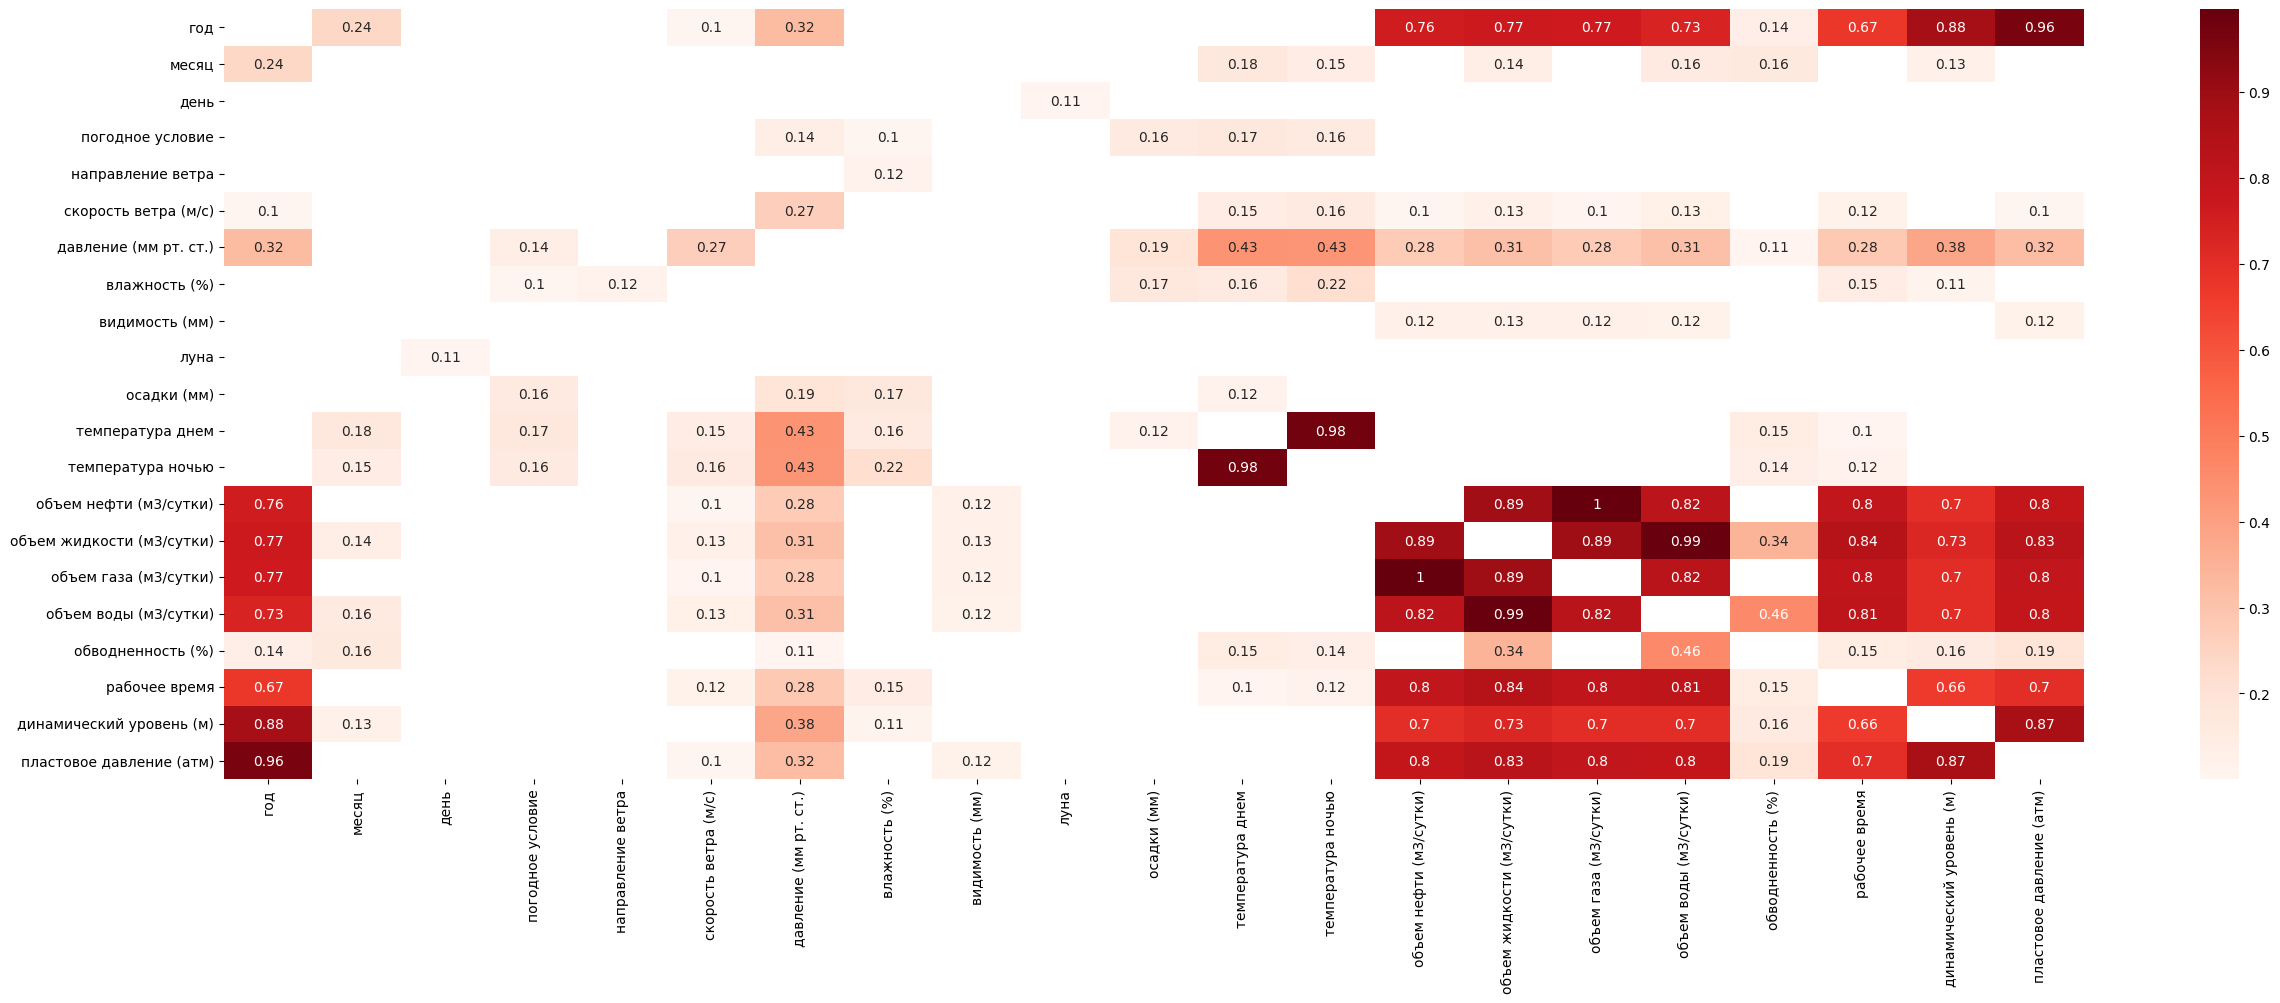

In [94]:
# наглядный график с высокой корреляцией
dataCorr = data.corr()
filteredDf = dataCorr[(abs(dataCorr) >= .1) & (dataCorr != 1.000)]
plt.figure(figsize=(30, 10))
sns.heatmap(abs(filteredDf), annot=True, cmap="Reds")
plt.show()

# Я не учитываю в корреляции ['погодное условие', 'направление ветра', 'луна'] так как это категориальные данные переведенные в число.

In [10]:
# Разделение для задачи классификации на X (экзогенные переменные, т.е. регрессоры или независимые) и y (эндогенные переменные или зависимые)

# Уберу не нужные данные с датой, так как я не буду исследовать данные в зависимости от времени года
data_ml = data.drop(['год', 'месяц', 'день'], axis=1)

# ['
#   'погодное условие',
#   'направление ветра',
#   'скорость ветра (м/с)',
#   'давление (мм рт. ст.)',
#   'влажность (%)',
#   'видимость (мм)',
#   'луна',
#   'осадки (мм)',
#   'температура днем',
#   'температура ночью'
# ]

# ['
#   'объем нефти (м3/сутки)',
#   'объем жидкости (м3/сутки)',
#   'объем газа (м3/сутки)',
#   'объем воды (м3/сутки)',
#   'обводненность (%)',
#   'рабочее время',
#   'динамический уровень (м)',
#   'пластовое давление (атм)'
# ]

X = data_ml.drop([
  'объем нефти (м3/сутки)',
  'объем жидкости (м3/сутки)',
  'объем газа (м3/сутки)',
  'объем воды (м3/сутки)',
  'обводненность (%)',
  'рабочее время',
  'динамический уровень (м)',
  'пластовое давление (атм)'
], axis=1)

y = data_ml[[
  'объем нефти (м3/сутки)',
  'объем жидкости (м3/сутки)',
  'объем газа (м3/сутки)',
  'объем воды (м3/сутки)',
  'обводненность (%)',
  'рабочее время',
  'динамический уровень (м)',
  'пластовое давление (атм)'
]]

In [11]:
# Подготовка данных

# Нормализация (MinMaxScaler)
scalar = MinMaxScaler()
features = scalar.fit_transform(X, y)
X_normalised = pd.DataFrame(features, columns=X.columns)
X_normalised

,погодное условие,направление ветра,скорость ветра (м/с),давление (мм рт. ст.),влажность (%),видимость (мм),луна,осадки (мм),температура днем,температура ночью
0,0.6,0.571429,0.069767,0.454545,0.56,0.009738,0.666667,0.0,0.820896,0.776316
1,1.0,0.571429,0.046512,0.428571,0.63,0.009738,0.666667,0.0,0.820896,0.776316
2,0.2,0.285714,0.046512,0.350649,0.51,0.009738,0.333333,0.0,0.865672,0.802632
3,0.6,0.571429,0.162791,0.298701,0.60,0.009738,1.000000,0.0,0.835821,0.736842
4,0.6,0.142857,0.116279,0.350649,0.50,0.009738,1.000000,0.0,0.746269,0.631579
...,...,...,...,...,...,...,...,...,...,...
1310,0.8,0.142857,0.162791,0.441558,0.95,0.414597,0.666667,0.0,0.492537,0.434211
1311,0.6,0.857143,0.046512,0.532468,0.87,0.009738,0.666667,0.0,0.388060,0.328947
1312,0.6,0.714286,0.093023,0.389610,0.93,0.006894,0.666667,0.0,0.432836,0.394737
1313,0.8,0.000000,0.162791,0.233766,0.93,0.143232,0.666667,0.0,0.402985,0.355263


In [249]:
# Построить распределение для всех числовых нормализированных переменных
figure = px.box(X_normalised)
figure.show()

In [12]:
# Разделение на тренировочную (80%), тестовую (10%) и валидационную (10%) для классификации
X_train, X_test, y_train, y_test = train_test_split(X_normalised, y, test_size=0.2, random_state=1024, shuffle=True)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=1024, shuffle=True)

# Рассмотрю разные алгоритмы
models = [
  LinearRegression(), # Метод наименьших квадратов
  RandomForestRegressor(n_estimators=100, max_features ='sqrt'), # Случайный лес
  KNeighborsRegressor(n_neighbors=6), # Метод ближайших соседей
  # SVR(kernel='linear'), # Метод опорных векторов с линейным ядром (для одномерного массива y)
  # LogisticRegression() # Логистическая регрессия (для одномерного массива y)
  # DecisionTreeClassifier(max_depth=4, random_state=42), # Деревья решений
  # RandomForestClassifier(min_samples_split=5, n_estimators=1000), # Ансамбли деревьев решений
  # GradientBoostingClassifier(max_depth=1, n_estimators=1000), # Ансамбли градиентного спуска
  # KNeighborsClassifier(n_neighbors=5), # Обучение модели K-ближайших соседей
]

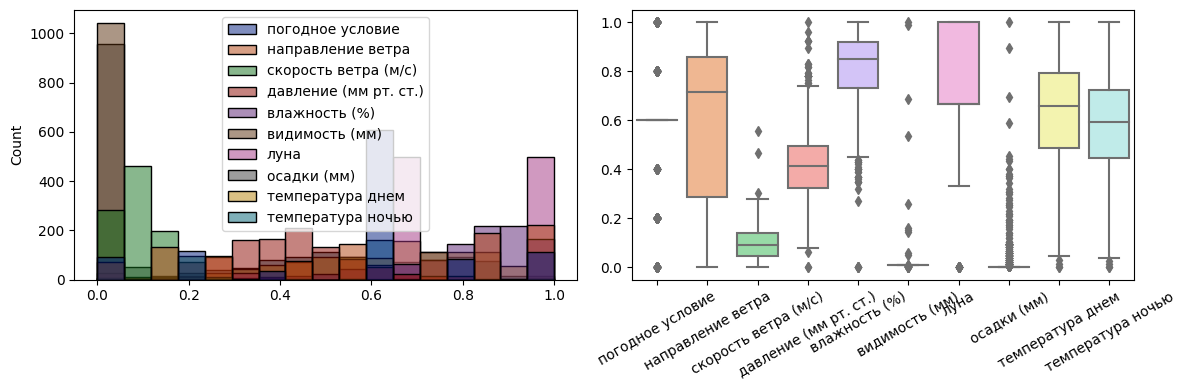

In [49]:
# Строю графики тренировочных данных
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
sns.histplot(data=X_train, ax=axes[0], palette='dark')
boxplot = sns.boxplot(data=X_train, ax=axes[1], palette='pastel')
boxplot.tick_params(axis='x', rotation=30)
plt.tight_layout()

In [122]:
# Создаю временную структуру для графика
models_test = pd.DataFrame()
models_temp = {}

# Для каждой модели из списка
for model in models:
  # Для каждого столбцам результирующего набора
  for i in range(y_train.shape[1]):
    # Обучаю модель
    model.fit(X_train, y_train.iloc[:, i])
    print(f"\nМодель {type(model).__name__}:")
    print("Правильность на обучающем наборе: {:.3f}".format(model.score(X_train, y_train.iloc[:, i])))
    print("Правильность на тестовом наборе: {:.3f}".format(model.score(X_test, y_test.iloc[:, i])))
    # Коэффициент детерминации
    models_temp[f'R2_y{i + 1}'] = r2_score(y_test.iloc[:, 0], model.predict(X_test))
  models_test = pd.concat([models_test, pd.DataFrame([models_temp])], ignore_index=True)


Модель LinearRegression:
Правильность на обучающем наборе: 0.128
Правильность на тестовом наборе: 0.079

Модель LinearRegression:
Правильность на обучающем наборе: 0.142
Правильность на тестовом наборе: 0.122

Модель LinearRegression:
Правильность на обучающем наборе: 0.129
Правильность на тестовом наборе: 0.075

Модель LinearRegression:
Правильность на обучающем наборе: 0.139
Правильность на тестовом наборе: 0.122

Модель LinearRegression:
Правильность на обучающем наборе: 0.044
Правильность на тестовом наборе: -0.011

Модель LinearRegression:
Правильность на обучающем наборе: 0.182
Правильность на тестовом наборе: 0.165

Модель LinearRegression:
Правильность на обучающем наборе: 0.257
Правильность на тестовом наборе: 0.268

Модель LinearRegression:
Правильность на обучающем наборе: 0.192
Правильность на тестовом наборе: 0.179

Модель RandomForestRegressor:
Правильность на обучающем наборе: 0.899
Правильность на тестовом наборе: 0.205

Модель RandomForestRegressor:
Правильность на об

In [14]:
# Коэффициенты детерминации
models_test_abs = models_test.abs()
models_test_abs

,R2_y1,R2_y2,R2_y3,R2_y4,R2_y5,R2_y6,R2_y7,R2_y8
0,0.078734,136.617551,1.003104e+06,63.064032,488.722200,12.731727,475800.692359,1552.887861
1,0.168337,138.837083,1.022275e+06,64.234841,488.148436,12.566725,476815.972811,1554.667800
2,0.083182,141.563418,1.031262e+06,65.850907,488.892107,12.980761,473280.184347,1576.112447


In [15]:
# Масштабирую данные о 0 до 1 относительно каждого столбца
models_test_normalized = (models_test_abs-models_test_abs.min()) / (models_test_abs.max()-models_test_abs.min())
models_test_normalized

,R2_y1,R2_y2,R2_y3,R2_y4,R2_y5,R2_y6,R2_y7,R2_y8
0,0.000000,0.000000,0.000000,0.000000,0.77153,0.398521,0.712856,0.00000
1,1.000000,0.448765,0.680834,0.420115,0.00000,0.000000,1.000000,0.07664
2,0.049639,1.000000,1.000000,1.000000,1.00000,1.000000,0.000000,1.00000


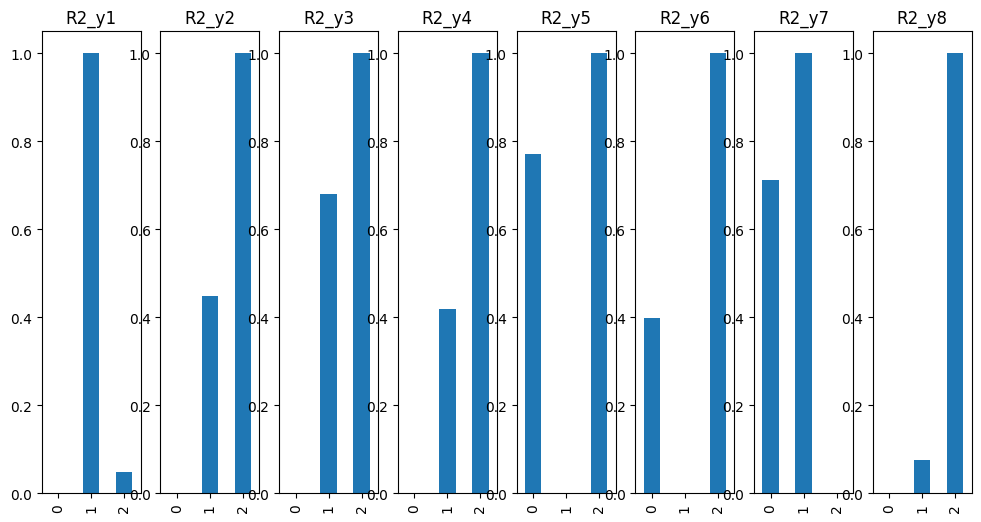

In [16]:
# Строю графики с коэффициентами детерминации
fig, axes = plt.subplots(ncols=y_train.shape[1], figsize=(12, 6))

for i in range(y_train.shape[1]):
  models_test_normalized[f'R2_y{i + 1}'].plot(ax=axes[i], kind='bar', title=f'R2_y{i + 1}')

In [256]:
# y1 = 'объем нефти (м3/сутки)',
# y2 = 'объем жидкости (м3/сутки)',
# y3 = 'объем газа (м3/сутки)',
# y4 = 'объем воды (м3/сутки)',
# y5 = 'обводненность (%)',
# y6 = 'рабочее время',
# y7 = 'динамический уровень (м)',
# y8 = 'пластовое давление (атм)'

# Как видно из графика:

# Метод наименьших квадратов (LinearRegression) подходит в большей степени для:
#   y5 = 'обводненность (%)',

# Случайный лес (RandomForestRegressor) подходит в большей степени для:
#   y3 = 'объем газа (м3/сутки)',
#   y4 = 'объем воды (м3/сутки)',
#   y7 = 'динамический уровень (м)',
#   y8 = 'пластовое давление (атм)'

# Метод ближайших соседей (KNeighborsRegressor) подходит в большей степени для:
#   y1 = 'объем нефти (м3/сутки)',
#   y2 = 'объем жидкости (м3/сутки)',
#   y4 = 'объем воды (м3/сутки)',
#   y5 = 'обводненность (%)',
#   y6 = 'рабочее время',

In [17]:
# Проведу анализ лучших признаков

# Для каждого столбца результирующего набора
for i in range(y_train.shape[1]):
  # Выбор 2 лучших признаков из 8 по Хи квадрат
  selector = SelectKBest(chi2, k=2)
  X_train_best = selector.fit_transform(X_train, y_train.iloc[:, i])
  # print(X_train_best.shape)
  X.columns[selector.get_support(indices=True)]
  vector_names = list(X.columns[selector.get_support(indices=True)])
  print(f'Для {[y.columns[i]]} лучшие признаки: {vector_names}')
  # X_train_best_df = pd.DataFrame(X_train_best, columns=selector.get_support(indices=True))
  # print(X_train_best_df)

Для ['объем нефти (м3/сутки)'] лучшие признаки: ['видимость (мм)', 'осадки (мм)']
Для ['объем жидкости (м3/сутки)'] лучшие признаки: ['видимость (мм)', 'осадки (мм)']
Для ['объем газа (м3/сутки)'] лучшие признаки: ['направление ветра', 'осадки (мм)']
Для ['объем воды (м3/сутки)'] лучшие признаки: ['видимость (мм)', 'температура ночью']
Для ['обводненность (%)'] лучшие признаки: ['температура днем', 'температура ночью']
Для ['рабочее время'] лучшие признаки: ['давление (мм рт. ст.)', 'видимость (мм)']
Для ['динамический уровень (м)'] лучшие признаки: ['осадки (мм)', 'температура днем']
Для ['пластовое давление (атм)'] лучшие признаки: ['температура днем', 'температура ночью']


In [53]:
# обучение лучшей модели с лучшими признаками
model_best = models[2]
model_best.fit(X_train, y_train)

# качество модели
score = model.score(X_test,y_test)
print("Accuracy: ", score*100) # A, P, R, E

Accuracy:  -0.3609410049226727


In [54]:
# предсказание на тестовой выборке
data_best = pd.DataFrame(model_best.predict(X_test), columns=[
  'объем нефти (м3/сутки)',
  'объем жидкости (м3/сутки)',
  'объем газа (м3/сутки)',
  'объем воды (м3/сутки)',
  'обводненность (%)',
  'рабочее время',
  'динамический уровень (м)',
  'пластовое давление (атм)'
])
data_best

,объем нефти (м3/сутки),объем жидкости (м3/сутки),объем газа (м3/сутки),объем воды (м3/сутки),обводненность (%),рабочее время,динамический уровень (м),пластовое давление (атм)
0,9.500000,38.833333,2512.833333,29.500000,75.000000,18.333333,2097.000000,116.000000
1,10.666667,42.833333,2854.666667,32.166667,74.333333,20.000000,2011.833333,123.333333
2,12.333333,50.000000,3295.333333,38.000000,74.666667,22.666667,1906.166667,128.833333
3,13.000000,49.500000,3484.833333,36.666667,73.333333,21.833333,1938.000000,137.166667
4,8.833333,37.666667,2415.666667,28.666667,76.000000,18.166667,2029.666667,118.500000
...,...,...,...,...,...,...,...,...
126,10.833333,41.000000,2906.333333,30.000000,73.166667,22.333333,2007.166667,123.666667
127,10.333333,45.500000,2785.666667,35.166667,75.666667,20.333333,2018.000000,121.666667
128,11.833333,45.500000,3136.333333,33.833333,73.500000,22.333333,1947.333333,129.833333
129,12.833333,50.333333,3413.500000,37.666667,74.166667,22.000000,1949.166667,132.833333


In [119]:
# score модели (метрики для классификации)
def model_report(model, X_train, y_train, X_test, y_test, average='weighted'):
  # Делаю предсказания на тренировочном наборе
  y_pred_train = model.predict(X_train)
  # Делаю предсказания на тестовом наборе
  y_pred_test = model.predict(X_test)

  # Оцениваю точность модели на тренировочном наборе
  print(f"Тренировочный набор - Матрица ошибок (confusion matrix) модели:\n{confusion_matrix(y_train, y_pred_train)}")
  print(f"Тренировочный набор - Правильность (accuracy) модели: {accuracy_score(y_train, y_pred_train)}")
  print(f"Тренировочный набор - Точность (precision) модели: {precision_score(y_train, y_pred_train, average=average)}")
  print(f"Тренировочный набор - Полнота (recall) модели: {recall_score(y_train, y_pred_train, average=average)}")
  print(f"Тренировочный набор - F1 мера модели: {f1_score(y_train, y_pred_train, average=average)}")
  print(f"Тренировочный набор - Средняя абсолютная ошибка (mean absolute error): {mean_absolute_error(y_train, y_pred_train)}\n\n")

  # Оцениваю точность модели на тестовом наборе
  print(f"Тестовый набор - Матрица ошибок (confusion matrix) модели:\n{confusion_matrix(y_test, y_pred_test)}")
  print(f"Тестовый набор - Правильность (accuracy) модели: {accuracy_score(y_test, y_pred_test)}")
  print(f"Тестовый набор - Точность (precision) модели: {precision_score(y_test, y_pred_test, average=average)}")
  print(f"Тестовый набор - Полнота (recall) модели: {recall_score(y_test, y_pred_test, average=average)}")
  print(f"Тестовый набор - F1 мера модели: {f1_score(y_test, y_pred_test, average=average)}")
  print(f"Тестовый набор - Средняя абсолютная ошибка (mean absolute error): {mean_absolute_error(y_test, y_pred_test)}\n\n")

In [142]:
# Сделаю обучение (KNeighborsRegressor) влияние температуры на пластовое давление
KNeighbors = KNeighborsRegressor(n_neighbors=6)
KNeighbors.fit(X_train[['температура днем', 'температура ночью']], y_train[['пластовое давление (атм)']])
print(f"Тренировочный набор - {KNeighbors.score(X_train[['температура днем', 'температура ночью']], y_train[['пластовое давление (атм)']])}")
print(f"Тестовый набор - {KNeighbors.score(X_test[['температура днем', 'температура ночью']], y_test[['пластовое давление (атм)']])}")

Тренировочный набор - 0.17569929148467522
Тестовый набор - -0.19359959029617668


In [143]:
# Сделаю обучение (KNeighborsRegressor) влияние температуры на обводненность
KNeighbors = KNeighborsRegressor(n_neighbors=6)
KNeighbors.fit(X_train[['температура днем', 'температура ночью']], y_train[['обводненность (%)']])
print(f"Тренировочный набор: {KNeighbors.score(X_train[['температура днем', 'температура ночью']], y_train[['обводненность (%)']])}")
print(f"Тестовый набор: {KNeighbors.score(X_test[['температура днем', 'температура ночью']], y_test[['обводненность (%)']])}")

Тренировочный набор: 0.16148008250982004
Тестовый набор: -0.19805909411103695


In [133]:
# вес каждого фактора в итоговой моделей
model_best.feature_importances_

# importance = model_best.coef_[0]
# feat_importances = pd.Series(importance)
# feat_importances.nlargest(20).plot(kind='barh',title = 'Feature Importance')

# pd.Series(data=model_best.feature_importances_,index=feature_names).plot(kind='bar')

AttributeError: 'KNeighborsRegressor' object has no attribute 'feature_importances_'